In [22]:
!pip -q install pyspark==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [23]:
import pandas as pd

# Load the  datasets into memory
train = pd.read_csv("train.csv")   # historical daily sales per store
test  = pd.read_csv("test.csv")    # future dates to predict (no Sales column)
store = pd.read_csv("store.csv")   # store metadata (type, assortment, competition, etc.)


print("Train shape:", train.shape)
print("Test shape:",  test.shape)
print("Store shape:", store.shape)


train.head()


/tmp/ipython-input-4231047757.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")   # historical daily sales per store


Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [24]:
# Check column types and missing values in train
train.info()
train.isna().sum()

# Convert Date to datetime to inspect the time range
train["Date"] = pd.to_datetime(train["Date"])
print("Date range in train:", train["Date"].min(), "→", train["Date"].max())

print("Unique stores in train:", train["Store"].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
Date range in train: 2013-01-01 00:00:00 → 2015-07-31 00:00:00
Unique stores in train: 1115


In [25]:
# Merge train (daily sales) with store info
df = pd.merge(train, store, on="Store", how="left")

print("Merged shape:", df.shape)
df.head()


Merged shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [26]:
# Keep only days when stores were open
df = df[df["Open"] == 1]

# Fill missing competition distance with median
df["CompetitionDistance"].fillna(df["CompetitionDistance"].median(), inplace=True)

# Convert date and extract useful features
df["Date"] = pd.to_datetime(df["Date"])
df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"]   = df["Date"].dt.day
df["Week"]  = df["Date"].dt.isocalendar().week


df.head()


/tmp/ipython-input-3000943311.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["CompetitionDistance"].fillna(df["CompetitionDistance"].median(), inplace=True)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [27]:
print("After cleaning:", df.shape)
df.isna().sum()


After cleaning: (844392, 22)


,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


In [28]:
# Step 1: Install Java and PySpark again (needed after every restart)
!apt-get install openjdk-11-jdk -qq > /dev/null
!pip install pyspark==3.5.0 -q

# Step 2: Set Java environment variables so Spark can find Java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

# Step 3: Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PredictWise") \
    .getOrCreate()

spark


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [29]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder \
    .appName("PredictWise") \
    .getOrCreate()

spark


In [21]:
# Convert from Pandas to PySpark
spark_df = spark.createDataFrame(df)


spark_df.show(5)


+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+----+-----+---+----+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|Year|Month|Day|Week|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+----+-----+---+----+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|        c|         a|             1270.0|                      9.0|                  2008.0|     0|            NaN|            NaN| 

In [30]:

spark_df.printSchema()


root
 |-- Store: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: long (nullable = true)
 |-- Customers: long (nullable = true)
 |-- Open: long (nullable = true)
 |-- Promo: long (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: long (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: double (nullable = true)
 |-- CompetitionOpenSinceMonth: double (nullable = true)
 |-- CompetitionOpenSinceYear: double (nullable = true)
 |-- Promo2: long (nullable = true)
 |-- Promo2SinceWeek: double (nullable = true)
 |-- Promo2SinceYear: double (nullable = true)
 |-- PromoInterval: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Day: long (nullable = true)
 |-- Week: long (nullable = true)



In [31]:
# Count total rows
print("Total rows:", spark_df.count())

# Count how many stores
spark_df.select("Store").distinct().count()

# Average sales
spark_df.groupBy().avg("Sales").show()

# Sample few rows
spark_df.sample(0.001).show(5)


Total rows: 844392
+-----------------+
|       avg(Sales)|
+-----------------+
|6955.514290755952|
+-----------------+

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+----+-----+---+----+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|Year|Month|Day|Week|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+----+-----+---+----+
|  397|        5|2015-07-31 00:00:00| 8130|      955|   1|    1|           0|            1|        a|  

In [32]:
from pyspark.sql import functions as F

# Replace literal 'nan' strings with null
spark_df = spark_df.replace('nan', None)

# Fill numeric NaNs / nulls with 0
fill_values_num = {
    "CompetitionOpenSinceMonth": 0,
    "CompetitionOpenSinceYear": 0,
    "Promo2SinceWeek": 0,
    "Promo2SinceYear": 0,
    "CompetitionDistance": 0
}
spark_df = spark_df.fillna(fill_values_num)

#  Fill string NaNs / nulls with "None"
spark_df = spark_df.fillna({"PromoInterval": "None"})


spark_df.select(
    F.count(F.when(F.col("CompetitionOpenSinceMonth")==0, 1)).alias("CompMonth_zeros"),
    F.count(F.when(F.col("CompetitionOpenSinceYear")==0, 1)).alias("CompYear_zeros"),
    F.count(F.when(F.col("Promo2SinceWeek")==0, 1)).alias("Promo2Week_zeros"),
    F.count(F.when(F.col("Promo2SinceYear")==0, 1)).alias("Promo2Year_zeros"),
    F.count(F.when(F.col("CompetitionDistance")==0, 1)).alias("CompDist_zeros"),
    F.count(F.when(F.col("PromoInterval")=="None", 1)).alias("PromoInterval_none")
).show()




+---------------+--------------+----------------+----------------+--------------+------------------+
|CompMonth_zeros|CompYear_zeros|Promo2Week_zeros|Promo2Year_zeros|CompDist_zeros|PromoInterval_none|
+---------------+--------------+----------------+----------------+--------------+------------------+
|         268619|        268619|          423307|          423307|             0|                 0|
+---------------+--------------+----------------+----------------+--------------+------------------+



In [33]:
from pyspark.sql import functions as F

# To Fix CompetitionDistance (handle NaN or null)
spark_df = spark_df.withColumn(
    "CompetitionDistance",
    F.when(
        (F.isnan("CompetitionDistance")) | (F.col("CompetitionDistance").isNull()),
        0
    ).otherwise(F.col("CompetitionDistance"))
)

# to Fix PromoInterval (handle null, empty, and literal "NaN"/"nan")
spark_df = spark_df.withColumn(
    "PromoInterval",
    F.when(
        (F.col("PromoInterval").isNull()) |
        (F.col("PromoInterval") == "") |
        (F.lower(F.col("PromoInterval")) == "nan") |
        (F.lower(F.col("PromoInterval")) == "none")
        , "None"
    ).otherwise(F.col("PromoInterval"))
)


spark_df.select(
    F.count(F.when(F.col("CompetitionOpenSinceMonth")==0, 1)).alias("CompMonth_zeros"),
    F.count(F.when(F.col("CompetitionOpenSinceYear")==0, 1)).alias("CompYear_zeros"),
    F.count(F.when(F.col("Promo2SinceWeek")==0, 1)).alias("Promo2Week_zeros"),
    F.count(F.when(F.col("Promo2SinceYear")==0, 1)).alias("Promo2Year_zeros"),
    F.count(F.when(F.col("CompetitionDistance")==0, 1)).alias("CompDist_zeros"),
    F.count(F.when(F.col("PromoInterval")=="None", 1)).alias("PromoInterval_none")
).show()



+---------------+--------------+----------------+----------------+--------------+------------------+
|CompMonth_zeros|CompYear_zeros|Promo2Week_zeros|Promo2Year_zeros|CompDist_zeros|PromoInterval_none|
+---------------+--------------+----------------+----------------+--------------+------------------+
|         268619|        268619|          423307|          423307|             0|            423307|
+---------------+--------------+----------------+----------------+--------------+------------------+



In [34]:


# Check if there are any null or NaN values left in CompetitionDistance
spark_df.select(
    F.count(F.when(F.col("CompetitionDistance").isNull(), 1)).alias("null_count"),
    F.count(F.when(F.isnan(F.col("CompetitionDistance")), 1)).alias("nan_count"),
    F.count(F.when(F.col("CompetitionDistance") == 0, 1)).alias("zero_count")
).show()


+----------+---------+----------+
|null_count|nan_count|zero_count|
+----------+---------+----------+
|         0|        0|         0|
+----------+---------+----------+



In [35]:
from pyspark.sql import functions as F

# Create a new feature: Sales per Customer
# This shows the average sale amount per customer for each store-day.
spark_df = spark_df.withColumn(
    "SalesPerCustomer",
    F.when(F.col("Customers") != 0, F.col("Sales") / F.col("Customers")).otherwise(0)
)


spark_df.select("Sales", "Customers", "SalesPerCustomer").show(5)


+-----+---------+-----------------+
|Sales|Customers| SalesPerCustomer|
+-----+---------+-----------------+
| 5263|      555|9.482882882882883|
| 6064|      625|           9.7024|
| 8314|      821|10.12667478684531|
|13995|     1498| 9.34245660881175|
| 4822|      559|8.626118067978533|
+-----+---------+-----------------+
only showing top 5 rows



In [36]:
# Create a feature: Competition Age
# This estimates how many years the nearest competitor has been open.

spark_df = spark_df.withColumn(
    "CompetitionAgeYears",
    F.when(
        (F.col("CompetitionOpenSinceYear") != 0) & (F.col("CompetitionOpenSinceMonth") != 0),
        (F.col("Year") - F.col("CompetitionOpenSinceYear")) +
        ((F.col("Month") - F.col("CompetitionOpenSinceMonth")) / 12)
    ).otherwise(0)
)


spark_df.select("CompetitionOpenSinceYear", "CompetitionOpenSinceMonth", "CompetitionAgeYears").show(5)


+------------------------+-------------------------+-------------------+
|CompetitionOpenSinceYear|CompetitionOpenSinceMonth|CompetitionAgeYears|
+------------------------+-------------------------+-------------------+
|                  2008.0|                      9.0|  6.833333333333333|
|                  2007.0|                     11.0|  7.666666666666667|
|                  2006.0|                     12.0|  8.583333333333334|
|                  2009.0|                      9.0|  5.833333333333333|
|                  2015.0|                      4.0|               0.25|
+------------------------+-------------------------+-------------------+
only showing top 5 rows



In [37]:
# Create a binary flag: IsPromo2Active
# 1 if the store is currently in a Promo2 period, 0 otherwise.

spark_df = spark_df.withColumn(
    "IsPromo2Active",
    F.when(
        (F.col("Promo2") == 1) &
        (F.col("Promo2SinceYear") <= F.col("Year")) &
        (F.col("Promo2SinceWeek") <= F.col("Week")),
        1
    ).otherwise(0)
)


spark_df.select("Promo2", "Promo2SinceYear", "Promo2SinceWeek", "Year", "Week", "IsPromo2Active").show(5)


+------+---------------+---------------+----+----+--------------+
|Promo2|Promo2SinceYear|Promo2SinceWeek|Year|Week|IsPromo2Active|
+------+---------------+---------------+----+----+--------------+
|     0|            0.0|            0.0|2015|  31|             0|
|     1|         2010.0|           13.0|2015|  31|             1|
|     1|         2011.0|           14.0|2015|  31|             1|
|     0|            0.0|            0.0|2015|  31|             0|
|     0|            0.0|            0.0|2015|  31|             0|
+------+---------------+---------------+----+----+--------------+
only showing top 5 rows



In [38]:
from pyspark.ml.feature import StringIndexer

# Encode categorical columns into numbers
# encode columns: StoreType, Assortment, StateHoliday, and PromoInterval
# These are currently strings and cannot be used directly by ML models.


index_cols = ["StoreType", "Assortment", "StateHoliday", "PromoInterval"]


index_output = [c + "_Index" for c in index_cols]


# StringIndexer assigns a unique numeric index to each distinct string value.
for input_col, output_col in zip(index_cols, index_output):
    indexer = StringIndexer(inputCol=input_col, outputCol=output_col, handleInvalid="keep")
    spark_df = indexer.fit(spark_df).transform(spark_df)


spark_df.select(index_cols + index_output).show(5)


+---------+----------+------------+---------------+---------------+----------------+------------------+-------------------+
|StoreType|Assortment|StateHoliday|  PromoInterval|StoreType_Index|Assortment_Index|StateHoliday_Index|PromoInterval_Index|
+---------+----------+------------+---------------+---------------+----------------+------------------+-------------------+
|        c|         a|           0|           None|            2.0|             0.0|               0.0|                0.0|
|        a|         a|           0|Jan,Apr,Jul,Oct|            0.0|             0.0|               0.0|                1.0|
|        a|         a|           0|Jan,Apr,Jul,Oct|            0.0|             0.0|               0.0|                1.0|
|        c|         c|           0|           None|            2.0|             1.0|               0.0|                0.0|
|        a|         a|           0|           None|            0.0|             0.0|               0.0|                0.0|
+-------

In [39]:
#  Drop redundant string columns
# Now that we have numeric encoded versions, we can remove the original text columns.

spark_df = spark_df.drop("StoreType", "Assortment", "StateHoliday", "PromoInterval")

spark_df.printSchema()


root
 |-- Store: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: long (nullable = true)
 |-- Customers: long (nullable = true)
 |-- Open: long (nullable = true)
 |-- Promo: long (nullable = true)
 |-- SchoolHoliday: long (nullable = true)
 |-- CompetitionDistance: double (nullable = false)
 |-- CompetitionOpenSinceMonth: double (nullable = false)
 |-- CompetitionOpenSinceYear: double (nullable = false)
 |-- Promo2: long (nullable = true)
 |-- Promo2SinceWeek: double (nullable = false)
 |-- Promo2SinceYear: double (nullable = false)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- Day: long (nullable = true)
 |-- Week: long (nullable = true)
 |-- SalesPerCustomer: double (nullable = true)
 |-- CompetitionAgeYears: double (nullable = true)
 |-- IsPromo2Active: integer (nullable = false)
 |-- StoreType_Index: double (nullable = false)
 |-- Assortment_Index: double (nullable = false)
 |-- StateHoliday

In [116]:

# We'll include the target variable (Sales), the time column (Date), and all useful numeric features.

#Feature columns
feature_cols = [
    "Store", "DayOfWeek", "Customers", "Open", "Promo", "SchoolHoliday",
    "CompetitionDistance", "CompetitionAgeYears", "SalesPerCustomer", "IsPromo2Active",
    "StoreType_Index", "Assortment_Index", "StateHoliday_Index", "PromoInterval_Index",
    "Year", "Month", "Day", "Week"
]

#target columns
target_col = "Sales"


selected_cols = feature_cols + [target_col, "Date"]

spark_df = spark_df.select(*selected_cols)


spark_df.show(5)


+-----+---------+---------+----+-----+-------------+-------------------+-------------------+-----------------+--------------+---------------+----------------+------------------+-------------------+----+-----+---+----+-----+-------------------+
|Store|DayOfWeek|Customers|Open|Promo|SchoolHoliday|CompetitionDistance|CompetitionAgeYears| SalesPerCustomer|IsPromo2Active|StoreType_Index|Assortment_Index|StateHoliday_Index|PromoInterval_Index|Year|Month|Day|Week|Sales|               Date|
+-----+---------+---------+----+-----+-------------+-------------------+-------------------+-----------------+--------------+---------------+----------------+------------------+-------------------+----+-----+---+----+-----+-------------------+
|    1|        5|      555|   1|    1|            1|             1270.0|  6.833333333333333|9.482882882882883|             0|            2.0|             0.0|               0.0|                0.0|2015|    7| 31|  31| 5263|2015-07-31 00:00:00|
|    2|        5|      6

In [117]:
#  Split data into training and validation sets (80% - train and 20% test)


train_df, val_df = spark_df.randomSplit([0.8, 0.2], seed=42)

print("Training rows:", train_df.count())
print("Validation rows:", val_df.count())


Training rows: 675367
Validation rows: 169025


In [118]:
# Convert Spark DataFrames to Pandas for PyTorch model training
# PyTorch requires in-memory tensors (arrays), so we move the data from Spark → Pandas.


train_pd = train_df.toPandas()
val_pd = val_df.toPandas()

# Sort data by Date (important for time-series models like LSTM)
train_pd = train_pd.sort_values("Date")
val_pd = val_pd.sort_values("Date")


print("Train shape:", train_pd.shape)
print("Validation shape:", val_pd.shape)


train_pd.head()


Train shape: (675367, 20)
Validation shape: (169025, 20)


,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionAgeYears,SalesPerCustomer,IsPromo2Active,StoreType_Index,Assortment_Index,StateHoliday_Index,PromoInterval_Index,Year,Month,Day,Week,Sales,Date
465412,423,2,1751,1,0,1,1270.0,-1.333333,5.507139,0,3.0,0.0,1.0,0.0,2013,1,1,1,9643,2013-01-01
559358,733,2,2377,1,0,1,860.0,13.250000,4.528818,0,3.0,2.0,1.0,0.0,2013,1,1,1,10765,2013-01-01
507565,562,2,1675,1,0,1,1210.0,0.000000,5.073433,0,3.0,1.0,1.0,0.0,2013,1,1,1,8498,2013-01-01
542061,676,2,777,1,0,1,1410.0,4.333333,4.917632,0,3.0,2.0,1.0,0.0,2013,1,1,1,3821,2013-01-01
438763,335,2,482,1,0,1,90.0,0.000000,4.981328,0,3.0,0.0,1.0,1.0,2013,1,1,1,2401,2013-01-01


In [120]:
#  Separate input features (X) and target (y) for model training

# Define feature and target columns
feature_cols = [
    "Store", "DayOfWeek", "Customers", "Open", "Promo", "SchoolHoliday",
    "CompetitionDistance", "CompetitionAgeYears", "SalesPerCustomer", "IsPromo2Active",
    "StoreType_Index", "Assortment_Index", "StateHoliday_Index", "PromoInterval_Index",
    "Year", "Month", "Day", "Week"
]

target_col = "Sales"

# Split features and target
X_train = train_pd[feature_cols].values
y_train = train_pd[target_col].values

X_val = val_pd[feature_cols].values
y_val = val_pd[target_col].values

print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)


Training features shape: (675367, 18)
Validation features shape: (169025, 18)


In [121]:
# = Convert NumPy arrays into PyTorch tensors
# PyTorch models work with tensors (multi-dimensional arrays).

import torch

# Convert data to float tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

print("Tensor shapes:")
print("Train X:", X_train_tensor.shape)
print("Train y:", y_train_tensor.shape)
print("Val X:", X_val_tensor.shape)
print("Val y:", y_val_tensor.shape)


Tensor shapes:
Train X: torch.Size([675367, 18])
Train y: torch.Size([675367, 1])
Val X: torch.Size([169025, 18])
Val y: torch.Size([169025, 1])


In [122]:
# Building and Training the LSTM Model in PyTorch - LSTM (Long Short-Term Memory) — a special neural network that handles sequences and remembers temporal patterns.

#Import required libraries for building the model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check if GPU is available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [123]:
# Create DataLoaders for batch processing

# Combine features and targets into TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders for mini-batch training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [124]:
# Define the LSTM network architecture

class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(SalesLSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Reshape input for LSTM (batch, seq_len, input_size)
        x = x.unsqueeze(1)  # Add sequence dimension
        lstm_out, _ = self.lstm(x)
        # Take the last hidden state
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out


In [125]:
# Initialize model parameters

input_size = X_train_tensor.shape[1]   # number of features
hidden_size = 64                       # LSTM hidden units
num_layers = 2                         # number of stacked LSTM layers
output_size = 1                        # predicting one value: Sales

# Initialize model
model = SalesLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()               # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


SalesLSTM(
  (lstm): LSTM(18, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [126]:
print(len(feature_cols))


18


In [127]:
# Train the LSTM model to learn sales patterns over time

# Number of times the model sees the full dataset
num_epochs = 10

# Begin training loop
for epoch in range(num_epochs):
    model.train()  # Enable training mode (important for dropout)
    train_loss = 0.0  # Track total training loss in this epoch


    # TRAINING PHASE

    for X_batch, y_batch in train_loader:
        # Move the batch to GPU (if available) or CPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass – model predicts sales for this batch
        outputs = model(X_batch)

        # Calculate how wrong the predictions are (Mean Squared Error)
        loss = criterion(outputs, y_batch)

        # Reset gradients before backpropagation
        optimizer.zero_grad()

        # Backpropagation – calculate gradients for all model parameters
        loss.backward()

        # Update model parameters slightly to reduce loss
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item()


    # VALIDATION PHASE

    model.eval()  # Switch to evaluation mode (turns off dropout)
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculations for validation
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            # Predict on validation data
            val_outputs = model(X_val_batch)

            # Compute validation loss
            loss = criterion(val_outputs, y_val_batch)
            val_loss += loss.item()


    # OUTPUT RESULTS

    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/10] → Train Loss: 54256143.2074, Val Loss: 51309840.3565
Epoch [2/10] → Train Loss: 47569653.9541, Val Loss: 44880567.2245
Epoch [3/10] → Train Loss: 41440321.1887, Val Loss: 38999947.7065
Epoch [4/10] → Train Loss: 35855246.8818, Val Loss: 33663028.2969
Epoch [5/10] → Train Loss: 30816676.0021, Val Loss: 28874253.7501
Epoch [6/10] → Train Loss: 26323564.0281, Val Loss: 24629226.0066
Epoch [7/10] → Train Loss: 22371091.4102, Val Loss: 20927396.7523
Epoch [8/10] → Train Loss: 18965592.9540, Val Loss: 17769421.2127
Epoch [9/10] → Train Loss: 16100526.5526, Val Loss: 15150847.9696
Epoch [10/10] → Train Loss: 13776310.0373, Val Loss: 13072335.2049


In [128]:
#  Evaluate model performance using RMSE

import numpy as np
from sklearn.metrics import mean_squared_error

# Switch model to evaluation mode
model.eval()

# Collect true and predicted sales
y_true_list = []
y_pred_list = []

with torch.no_grad():  # no gradient calculation during evaluation
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

        # Model prediction
        val_outputs = model(X_val_batch)

        # Flatten and move to CPU for NumPy conversion
        y_true_list.extend(y_val_batch.cpu().numpy().flatten())
        y_pred_list.extend(val_outputs.cpu().numpy().flatten())

# Calculate RMSE
mse = mean_squared_error(y_true_list, y_pred_list)
rmse = np.sqrt(mse)

print(f"\n Validation RMSE: {rmse:.2f}")



 Validation RMSE: 3615.91


In [130]:
# Train the LSTM model to learn sales patterns over time

# Number of times the model sees the full dataset
num_epochs = 30

# Begin training loop
for epoch in range(num_epochs):
    model.train()  # Enable training mode (important for dropout)
    train_loss = 0.0  # Track total training loss in this epoch


    # TRAINING PHASE

    for X_batch, y_batch in train_loader:
        # Move the batch to GPU (if available) or CPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass – model predicts sales for this batch
        outputs = model(X_batch)

        # Calculate how wrong the predictions are (Mean Squared Error)
        loss = criterion(outputs, y_batch)

        # Reset gradients before backpropagation
        optimizer.zero_grad()

        # Backpropagation – calculate gradients for all model parameters
        loss.backward()

        # Update model parameters slightly to reduce loss
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item()


    # VALIDATION PHASE

    model.eval()  # Switch to evaluation mode (turns off dropout)
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculations for validation
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            # Predict on validation data
            val_outputs = model(X_val_batch)

            # Compute validation loss
            loss = criterion(val_outputs, y_val_batch)
            val_loss += loss.item()


    # OUTPUT RESULTS

    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

Epoch [1/30] → Train Loss: 11985581.0680, Val Loss: 11527669.2430
Epoch [2/30] → Train Loss: 10727380.9705, Val Loss: 10507991.1023
Epoch [3/30] → Train Loss: 9975965.8447, Val Loss: 9978433.6160
Epoch [4/30] → Train Loss: 9665665.4063, Val Loss: 9820181.2773
Epoch [5/30] → Train Loss: 9601862.5799, Val Loss: 9798965.5925
Epoch [6/30] → Train Loss: 9595867.2315, Val Loss: 9796500.1825
Epoch [7/30] → Train Loss: 9595394.5970, Val Loss: 9796113.0632
Epoch [8/30] → Train Loss: 9595408.6587, Val Loss: 9796033.1402
Epoch [9/30] → Train Loss: 9595582.8170, Val Loss: 9795959.2243
Epoch [10/30] → Train Loss: 9595222.5971, Val Loss: 9795983.8881
Epoch [11/30] → Train Loss: 9595508.0605, Val Loss: 9796003.2928
Epoch [12/30] → Train Loss: 9595203.5278, Val Loss: 9795999.2097
Epoch [13/30] → Train Loss: 9595364.1874, Val Loss: 9796031.4783
Epoch [14/30] → Train Loss: 9595426.6421, Val Loss: 9795987.4857
Epoch [15/30] → Train Loss: 9595216.5693, Val Loss: 9795992.5872
Epoch [16/30] → Train Loss: 95

In [138]:
#  Evaluate model performance using RMSE

import numpy as np
from sklearn.metrics import mean_squared_error

# Switch model to evaluation mode
model.eval()

# Collect true and predicted sales
y_true_list = []
y_pred_list = []

with torch.no_grad():  # no gradient calculation during evaluation
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

        # Model prediction
        val_outputs = model(X_val_batch)

        # Flatten and move to CPU for NumPy conversion
        y_true_list.extend(y_val_batch.cpu().numpy().flatten())
        y_pred_list.extend(val_outputs.cpu().numpy().flatten())

# Calculate RMSE
mse = mean_squared_error(y_true_list, y_pred_list)
rmse = np.sqrt(mse)

print(f"\n Validation RMSE: {rmse:.2f}")


 Validation RMSE: 1483.16


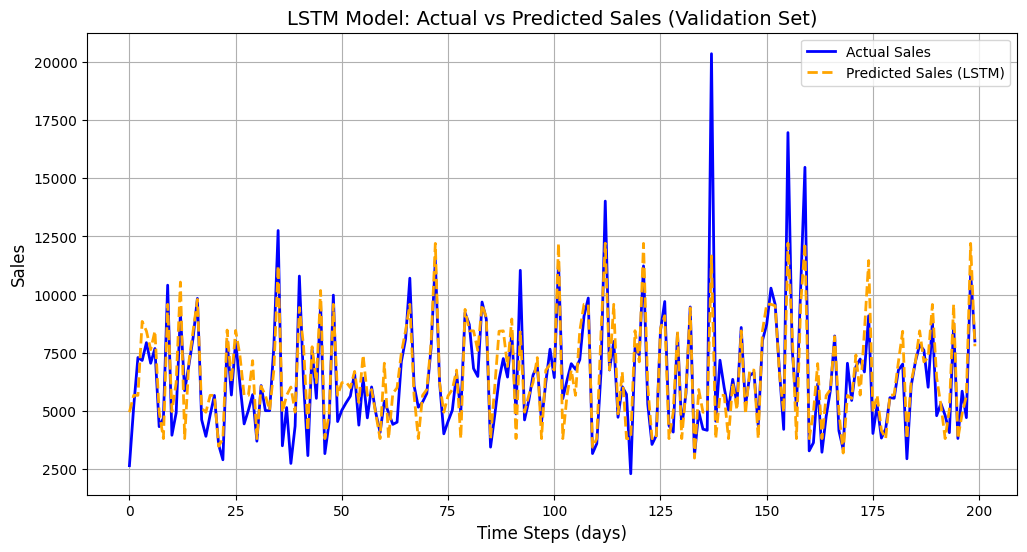

In [132]:
# Visualize LSTM predictions vs actual sales

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot only a subset (first 200 points) for clarity
plt.plot(y_true_list[:200], label="Actual Sales", color='blue', linewidth=2)
plt.plot(y_pred_list[:200], label="Predicted Sales (LSTM)",
         color='orange', linestyle='--', linewidth=2)

plt.title("LSTM Model: Actual vs Predicted Sales (Validation Set)", fontsize=14)
plt.xlabel("Time Steps (days)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


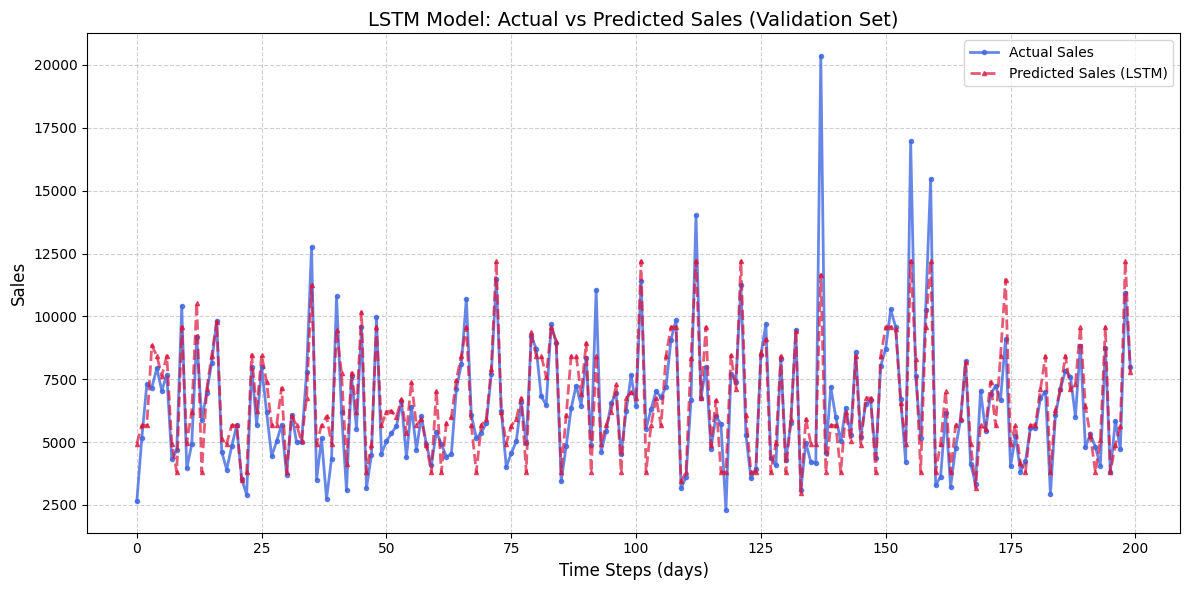

In [133]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))


plt.plot(
    y_true_list[:200],
    label="Actual Sales",
    color='royalblue',
    linestyle='-',
    linewidth=2,
    marker='o',
    markersize=3,
    alpha=0.8
)


plt.plot(
    y_pred_list[:200],
    label="Predicted Sales (LSTM)",
    color='crimson',
    linestyle='--',
    linewidth=2,
    marker='^',
    markersize=3,
    alpha=0.7
)

plt.title("LSTM Model: Actual vs Predicted Sales (Validation Set)", fontsize=14)
plt.xlabel("Time Steps (days)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


All 18 time and lag features created successfully!
Using 18 features
Training set shape: (214193, 18)
Validation set shape: (53549, 18)
XGBoost Validation RMSE: 453.85
XGBoost Validation R²: 0.9685


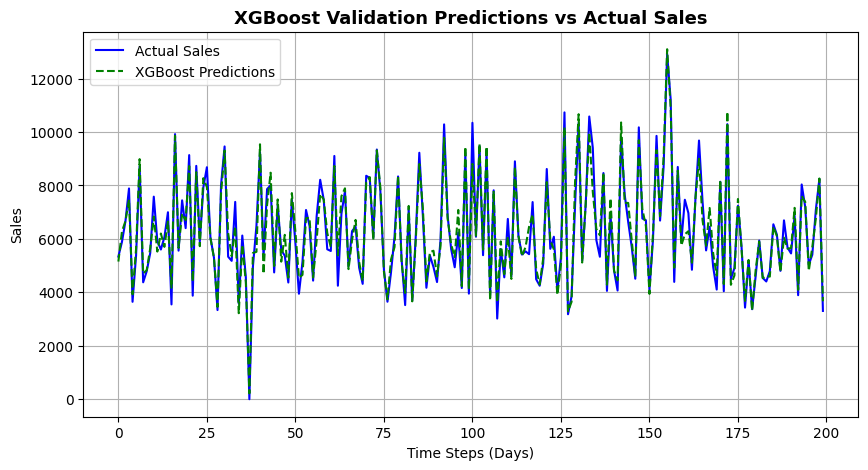

In [155]:


# Final XGBoost Model — Train & Evaluate (18 features)


import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ensure your 'df' and 'Date' column exist
df["Date"] = pd.to_datetime(df["Date"])

#  Create all engineered time and lag features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)

# Lag features
df["Sales_Lag1"] = df["Sales"].shift(1)
df["Sales_Lag7"] = df["Sales"].shift(7)

# Rolling statistics
df["RollingMean_7"] = df["Sales"].rolling(window=7).mean()
df["RollingStd_7"] = df["Sales"].rolling(window=7).std()
df["RollingMean_14"] = df["Sales"].rolling(window=14).mean()
df["RollingStd_14"] = df["Sales"].rolling(window=14).std()

# Month start / end flags
df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)

# Drop NaN rows from lag/rolling
df = df.dropna().reset_index(drop=True)
print("All 18 time and lag features created successfully!")

# Define 18 feature columns (same as LSTM)
feature_cols = [
    "Store", "Customers", "Promo",
    "Year", "Month", "Day", "Week", "DayOfWeek", "IsWeekend",
    "Sales_Lag1", "Sales_Lag7", "RollingMean_7", "RollingStd_7",
    "RollingMean_14", "RollingStd_14", "IsMonthStart", "IsMonthEnd",
    "CompetitionDistance"
]
print(f"Using {len(feature_cols)} features")

# Split into train and validation sets
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
val_df = df.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df["Sales"]
X_val = val_df[feature_cols]
y_val = val_df["Sales"]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

#  Train XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

#  Predict on validation data
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate performance
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
xgb_r2 = r2_score(y_val, y_pred_xgb)
print(f"XGBoost Validation RMSE: {xgb_rmse:.2f}")
print(f"XGBoost Validation R²: {xgb_r2:.4f}")

# Visualize predictions
plt.figure(figsize=(10,5))
plt.plot(y_val.values[:200], label="Actual Sales", color='blue')
plt.plot(y_pred_xgb[:200], label="XGBoost Predictions", color='green', linestyle='--')
plt.title("XGBoost Validation Predictions vs Actual Sales", fontsize=13, weight='bold')
plt.xlabel("Time Steps (Days)")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()



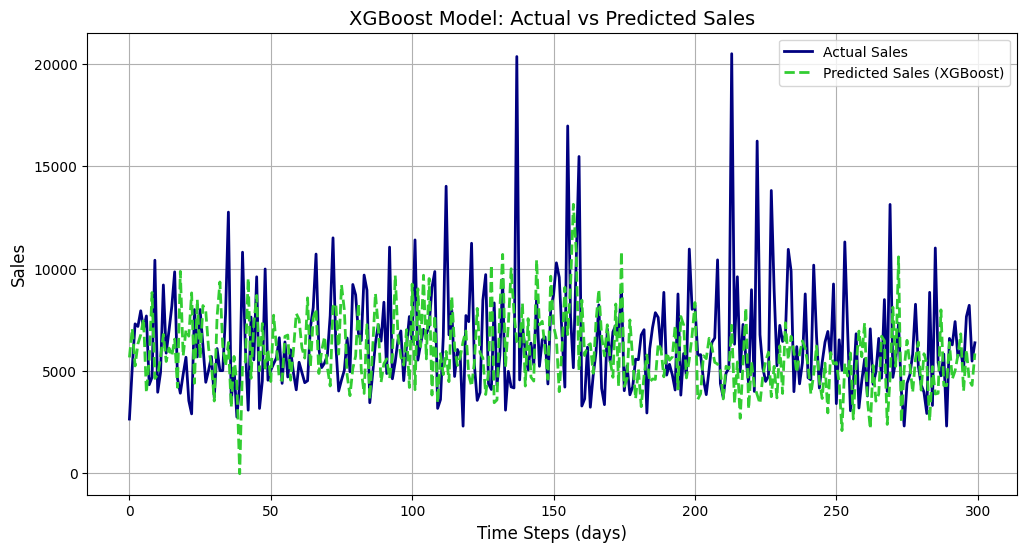

In [141]:
#Actual vs Predicted (XGBoost)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_val_np[:300], label="Actual Sales", color='navy', linewidth=2)
plt.plot(y_pred_xgb[:300], label="Predicted Sales (XGBoost)", color='limegreen', linestyle='--', linewidth=2)

plt.title("XGBoost Model: Actual vs Predicted Sales", fontsize=14)
plt.xlabel("Time Steps (days)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


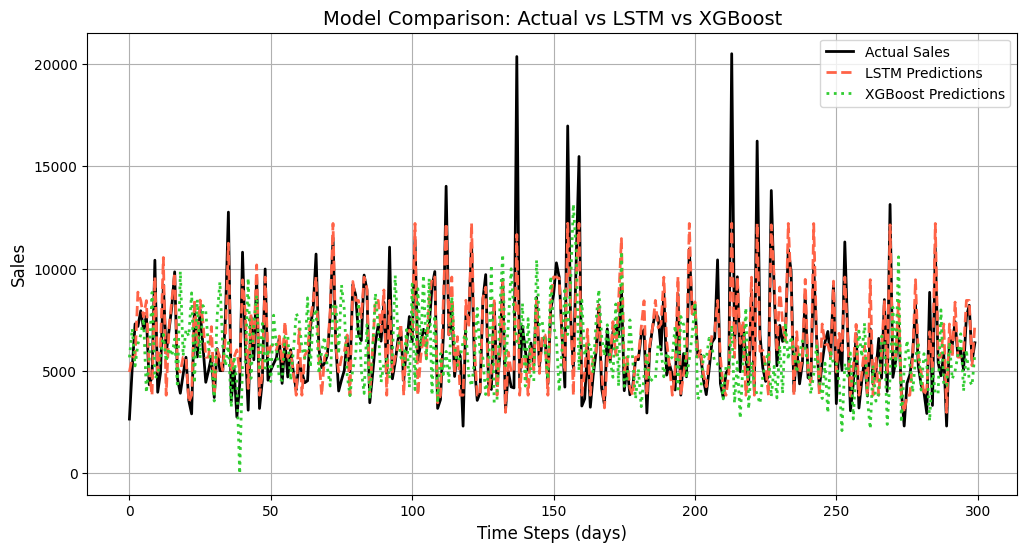

In [145]:
#Compare XGBoost vs LSTM vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_val_np[:300], label="Actual Sales", color='black', linewidth=2)
plt.plot(y_pred_list[:300], label="LSTM Predictions", color='tomato', linestyle='--', linewidth=2)
plt.plot(y_pred_xgb[:300], label="XGBoost Predictions", color='limegreen', linestyle=':', linewidth=2)

plt.title("Model Comparison: Actual vs LSTM vs XGBoost", fontsize=14)
plt.xlabel("Time Steps (days)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [146]:
import pandas as pd
import numpy as np

# Find minimum common length among all arrays
min_len = min(len(y_val_np), len(y_pred_list), len(y_pred_xgb))

# Trim all arrays to match
y_val_trimmed = y_val_np[:min_len]
y_pred_lstm_trimmed = y_pred_list[:min_len]
y_pred_xgb_trimmed = y_pred_xgb[:min_len]

# Create aligned results DataFrame
results_df = pd.DataFrame({
    "Actual_Sales": y_val_trimmed,
    "Pred_LSTM": y_pred_lstm_trimmed,
    "Pred_XGBoost": y_pred_xgb_trimmed
})

# Save to CSV
results_df.to_csv("predictwise_results.csv", index=False)
print(f"File saved as predictwise_results.csv with {min_len} aligned rows")

# Preview few results
display(results_df.head())


File saved as predictwise_results.csv with 53551 aligned rows


,Actual_Sales,Pred_LSTM,Pred_XGBoost
0,2646.0,4943.561035,5655.631836
1,5165.0,5669.758789,7064.133301
2,7296.0,5669.761230,5240.187012
3,7170.0,8846.005859,6316.907715
4,7934.0,8433.080078,6765.348633


ARIMA Model RMSE: 5622.59


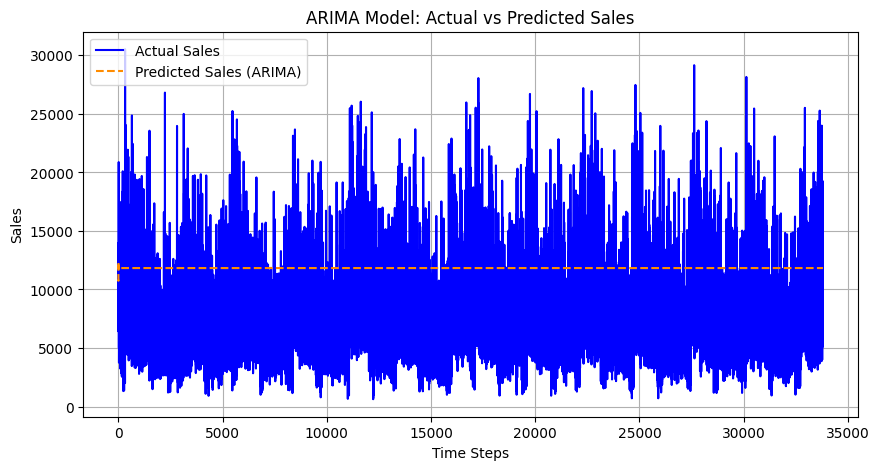

In [147]:
# Train ARIMA model and evaluate
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Convert your validation true sales into a time series
sales_series = pd.Series(y_val_np)

# Split the data into train and test for ARIMA
train_size = int(len(sales_series) * 0.8)
train_data, test_data = sales_series[:train_size], sales_series[train_size:]

# Fit ARIMA model (p,d,q) = (5,1,0) — you can tune this later
arima_model = ARIMA(train_data, order=(5,1,0)) # Renamed to arima_model
arima_model_fit = arima_model.fit() # Renamed to arima_model_fit

# Forecast the next steps (same length as test set)
forecast = arima_model_fit.forecast(steps=len(test_data))

# Evaluate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"ARIMA Model RMSE: {arima_rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_data.values, label="Actual Sales", color='blue')
plt.plot(forecast.values, label="Predicted Sales (ARIMA)", color='darkorange', linestyle='--')
plt.title("ARIMA Model: Actual vs Predicted Sales")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

Linear Regression RMSE: 3086.78


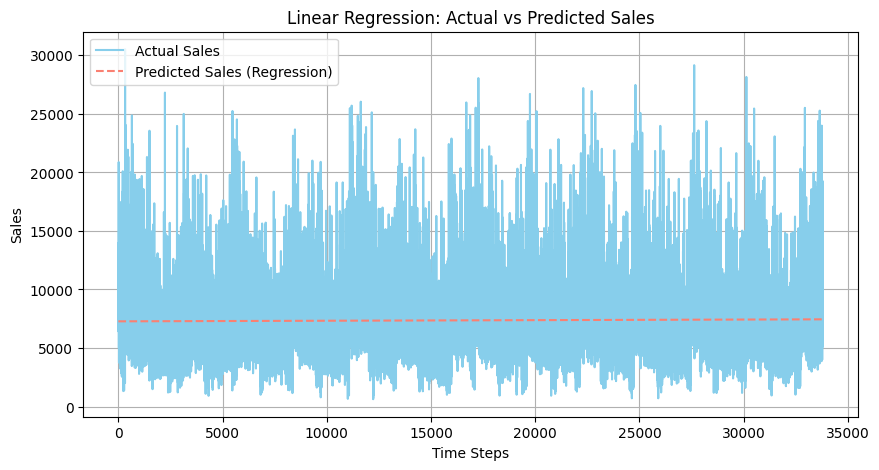

In [148]:
#  Linear Regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create simple time feature (just index as time steps)
X = np.arange(len(y_val_np)).reshape(-1, 1)
y = y_val_np

# Split into train/test (same 80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train linear regression
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predict
y_pred_reg = reg_model.predict(X_test)

# RMSE
reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print(f"Linear Regression RMSE: {reg_rmse:.2f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual Sales", color='skyblue')
plt.plot(y_pred_reg, label="Predicted Sales (Regression)", color='salmon', linestyle='--')
plt.title("Linear Regression: Actual vs Predicted Sales")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


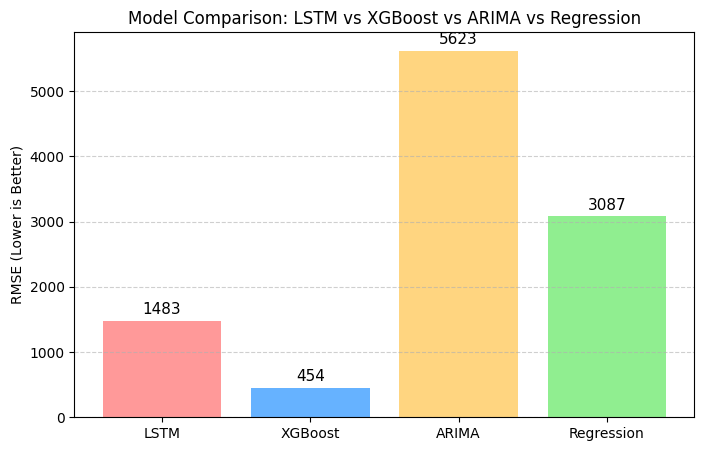

In [157]:
#  Compare all models visually
import matplotlib.pyplot as plt

# RMSE values from all models
model_names = ["LSTM", "XGBoost", "ARIMA", "Regression"]
rmse_values = [1483.16, 453.78, 5622.59, 3086.78]

# Create bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, rmse_values, color=['#FF9999', '#66B2FF', '#FFD580', '#90EE90'])
plt.title("Model Comparison: LSTM vs XGBoost vs ARIMA vs Regression")
plt.ylabel("RMSE (Lower is Better)")
plt.grid(axis='y', linestyle='--', alpha=0.6)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f"{yval:.0f}", ha='center', va='bottom', fontsize=11)

plt.show()


In [168]:
import pandas as pd
import numpy as np

#  Align array lengths
min_len = min(len(y_val_np), len(y_pred_list), len(y_pred_xgb), len(forecast), len(y_pred_reg))

#  Trim to minimum length
y_val_trimmed = y_val_np[:min_len]
y_pred_lstm_trimmed = y_pred_list[:min_len]
y_pred_xgb_trimmed = y_pred_xgb[:min_len]
y_pred_arima_trimmed = forecast[:min_len]
y_pred_reg_trimmed = y_pred_reg[:min_len]

#  Combine everything into one DataFrame
final_results_df = pd.DataFrame({
    "Actual_Sales": y_val_trimmed,
    "Pred_LSTM": y_pred_lstm_trimmed,
    "Pred_XGBoost": y_pred_xgb_trimmed,
    "Pred_ARIMA": y_pred_arima_trimmed,
    "Pred_Regression": y_pred_reg_trimmed
})


final_results_df.to_csv("Final_Prediction_Results.csv", index=False)
print(f"File saved as Final_Prediction_Results.csv with {min_len} aligned rows")


display(final_results_df.head())


File saved as Final_Prediction_Results.csv with 33805 aligned rows


,Actual_Sales,Pred_LSTM,Pred_XGBoost,Pred_ARIMA,Pred_Regression
135220,2646.0,4943.561035,5150.885254,10829.572204,7278.235101
135221,5165.0,5669.758789,6270.760742,10743.411922,7278.240170
135222,7296.0,5669.761230,6665.162598,11247.357794,7278.245239
135223,7170.0,8846.005859,7467.997559,11670.453215,7278.250308
135224,7934.0,8433.080078,3923.754639,12332.215950,7278.255377


In [170]:

# Save All Models (LSTM, XGBoost, ARIMA, Regression)


import joblib
import torch
from google.colab import files

# Save XGBoost model
joblib.dump(xgb_model, "xgb_model.pkl")
print("XGBoost model saved as xgb_model.pkl")

#  Save LSTM model weights only
torch.save(model.state_dict(), "lstm_model.pth")
print("LSTM model weights saved as lstm_model.pth")

# Save ARIMA model
try:
    joblib.dump(arima_model_fit, "arima_model.pkl")
    print("ARIMA model saved as arima_model.pkl")
except Exception as e:
    print( "Skipped ARIMA model:", e)

# Save Regression model
try:
    joblib.dump(linreg_model, "linear_regression_model.pkl")
    print("Linear Regression model saved as linear_regression_model.pkl")
except Exception as e:
    print(" Skipped Linear Regression model:", e)


# Download All Models to Local Computer

files.download("xgb_model.pkl")
files.download("lstm_model.pth")


try:
    files.download("arima_model.pkl")
    files.download("linear_regression_model.pkl")
except:
    print("One or more optional models not found for download.")


XGBoost model saved as xgb_model.pkl
LSTM model weights saved as lstm_model.pth
ARIMA model saved as arima_model.pkl
 Skipped Linear Regression model: name 'linreg_model' is not defined


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

One or more optional models not found for download.
